### CD4 T cell KO example

This notebook prepares a dataset with 24 individual knockout experiments applied to CD4 T cells ([Freimer et al 2020](https://www.nature.com/articles/s41588-022-01106-y)). Each knockout was profiled with both ATAC and RNA-seq measurements, but we use only RNA. The data have UMI's. Controls are 8 guide RNA's targeting the "safe-harbor" AAVS1 locus, and are labeled `AAVS1_1`, `AAVS1_8`, etc. The experiment was done separately on blood from 3 different donors.

Here we tidy the dataset and carry out a simple exploration in scanpy. (It's not single cell data but scanpy is still useful for data exploration.)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import sys
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML


#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Specify the working directory explicitly.
os.chdir("/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/perturbations/")

### Reshape the data

In [2]:
expression_quantified = pd.read_csv("not_ready/freimer/GSE171677_RNA_UMI_dedup_counts.txt", 
                              delimiter="\t",
                              index_col=0, 
                              header=0, 
                              comment = '!')   
gene_metadata   = expression_quantified.iloc[:,0:5]
expression_quantified = expression_quantified.iloc[:, 5:].T
sample_metadata = pd.DataFrame(columns = ["donor", "perturbation"], 
                               index = expression_quantified.index,
                               data = [g.split("_", maxsplit=2)[1:3] for g in expression_quantified.index])
print("\n\ngene_metadata\n")
display(gene_metadata.head())
print("\n\nsample_metadata\n")
display(sample_metadata.head())
print("\n\n expression_quantified\n")
display(expression_quantified.head().T.head())



gene_metadata



,Chr,Start,End,Strand,Length
Geneid,,,,,
ENSG00000223972.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1,11869;12010;12179;12613;12613;12975;13221;1322...,12227;12057;12227;12721;12697;13052;14409;1337...,+;+;+;+;+;+;+;+;+,1735
ENSG00000227232.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14404;15005;15796;16607;16858;17233;17606;1791...,14501;15038;15947;16765;17055;17368;17742;1806...,-;-;-;-;-;-;-;-;-;-;-,1351
ENSG00000278267.1,chr1,17369,17436,-,68
ENSG00000243485.5,chr1;chr1;chr1;chr1;chr1,29554;30267;30564;30976;30976,30039;30667;30667;31097;31109,+;+;+;+;+,1021
ENSG00000284332.1,chr1,30366,30503,+,138




sample_metadata



,donor,perturbation
Donor_1_AAVS1_4,1,AAVS1_4
Donor_1_STAT5B,1,STAT5B
Donor_1_AAVS1_7,1,AAVS1_7
Donor_1_TNFAIP3,1,TNFAIP3
Donor_1_MYB,1,MYB




 expression_quantified



,Donor_1_AAVS1_4,Donor_1_STAT5B,Donor_1_AAVS1_7,Donor_1_TNFAIP3,Donor_1_MYB
Geneid,,,,,
ENSG00000223972.5,0,0,0,0,0
ENSG00000227232.5,0,0,0,0,1
ENSG00000278267.1,0,0,0,0,0
ENSG00000243485.5,0,0,0,0,0
ENSG00000284332.1,0,0,0,0,0


### Combine into anndata to keep everything together

In [3]:
expression_quantified = sc.AnnData(expression_quantified, 
                             var = gene_metadata.copy(),
                             obs = sample_metadata.copy())
# DRY these up once they're in AnnData
del gene_metadata
del sample_metadata

### Convert ensembl gene id's to gene symbol

In [4]:
# parse gtf
gene_identifiers = pd.read_csv("setup/accessory_data/gencode.v35.annotation.gtf.gz", 
                               sep = "\t", 
                               comment = "#", 
                               header=None)
gene_identifiers = gene_identifiers.loc[:, [8]]
gene_identifiers = gene_identifiers.drop_duplicates()
gene_identifiers["ensembl_id"] = [[g for g in s.split(";") if "gene_id " in g][0] for s in gene_identifiers[8]]
gene_identifiers["ensembl_id"] = gene_identifiers["ensembl_id"].str.replace('"|gene_id| ', '')
gene_identifiers["symbol"] = [[g for g in s.split(";") if "gene_name" in g] for s in gene_identifiers[8]]
gene_identifiers["symbol"] = [l[0] if len(l)>0 else None for l in gene_identifiers["symbol"]]
gene_identifiers["symbol"] = gene_identifiers["symbol"].str.replace('"|gene_name| ', '')
gene_identifiers = gene_identifiers[["ensembl_id", "symbol"]]
gene_identifiers.drop_duplicates(inplace = True)
gene_identifiers.set_index("ensembl_id", inplace = True)
gene_identifiers.drop_duplicates(inplace = True) #same symbol, different ens id

In [5]:
# do conversion
expression_quantified.var_names = [gene_identifiers.loc[eg, "symbol"] if eg in gene_identifiers.index and gene_identifiers.loc[eg, "symbol"] is not None else eg 
                                   for eg in expression_quantified.var_names]
display(expression_quantified.var.head())
display(expression_quantified.var_names[0:5])

,Chr,Start,End,Strand,Length
DDX11L1,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1,11869;12010;12179;12613;12613;12975;13221;1322...,12227;12057;12227;12721;12697;13052;14409;1337...,+;+;+;+;+;+;+;+;+,1735
WASH7P,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14404;15005;15796;16607;16858;17233;17606;1791...,14501;15038;15947;16765;17055;17368;17742;1806...,-;-;-;-;-;-;-;-;-;-;-,1351
MIR6859-1,chr1,17369,17436,-,68
MIR1302-2HG,chr1;chr1;chr1;chr1;chr1,29554;30267;30564;30976;30976,30039;30667;30667;31097;31109,+;+;+;+;+,1021
MIR1302-2,chr1,30366,30503,+,138


Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2'], dtype='object')

In [6]:
# Document controls with weird names
controls = [f"AAVS1_{i}" for i in range(1,9)]
for c in controls:
    assert c in expression_quantified.obs['perturbation'].unique() 
expression_quantified.obs["is_control"] = expression_quantified.obs['perturbation'].isin(controls).astype(int)

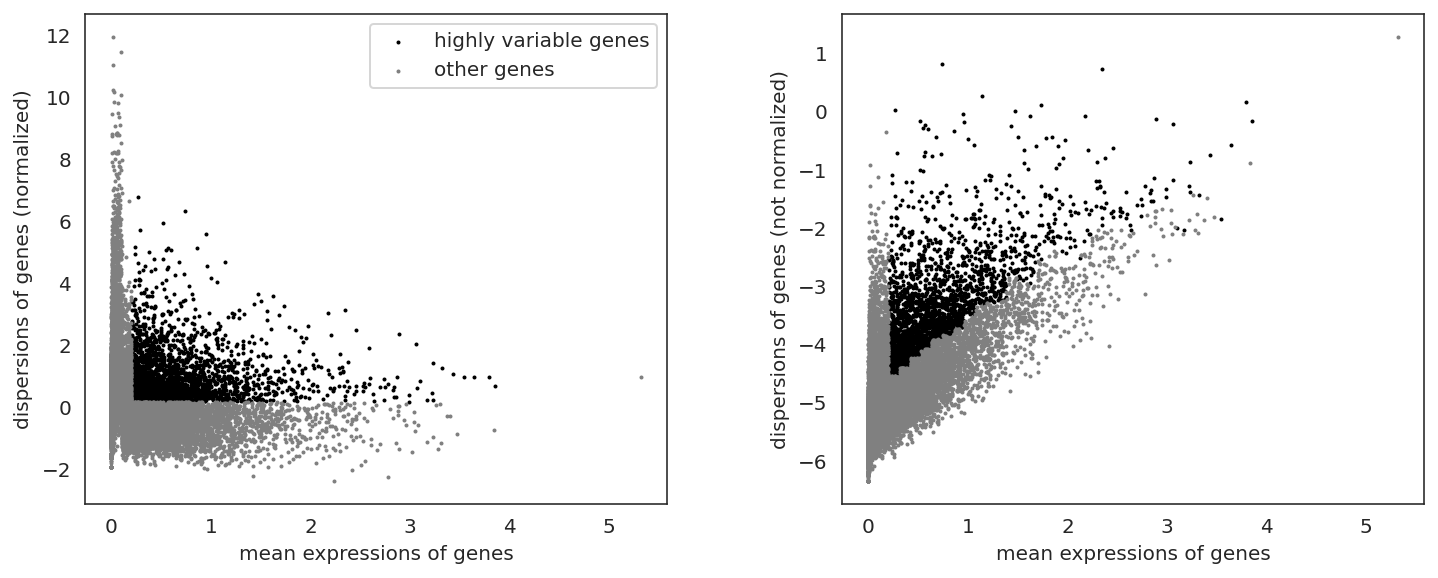

In [7]:
sc.pp.normalize_total(expression_quantified, target_sum=1e4)
sc.pp.log1p(expression_quantified)
sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=3)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []
sc.tl.leiden(expression_quantified)

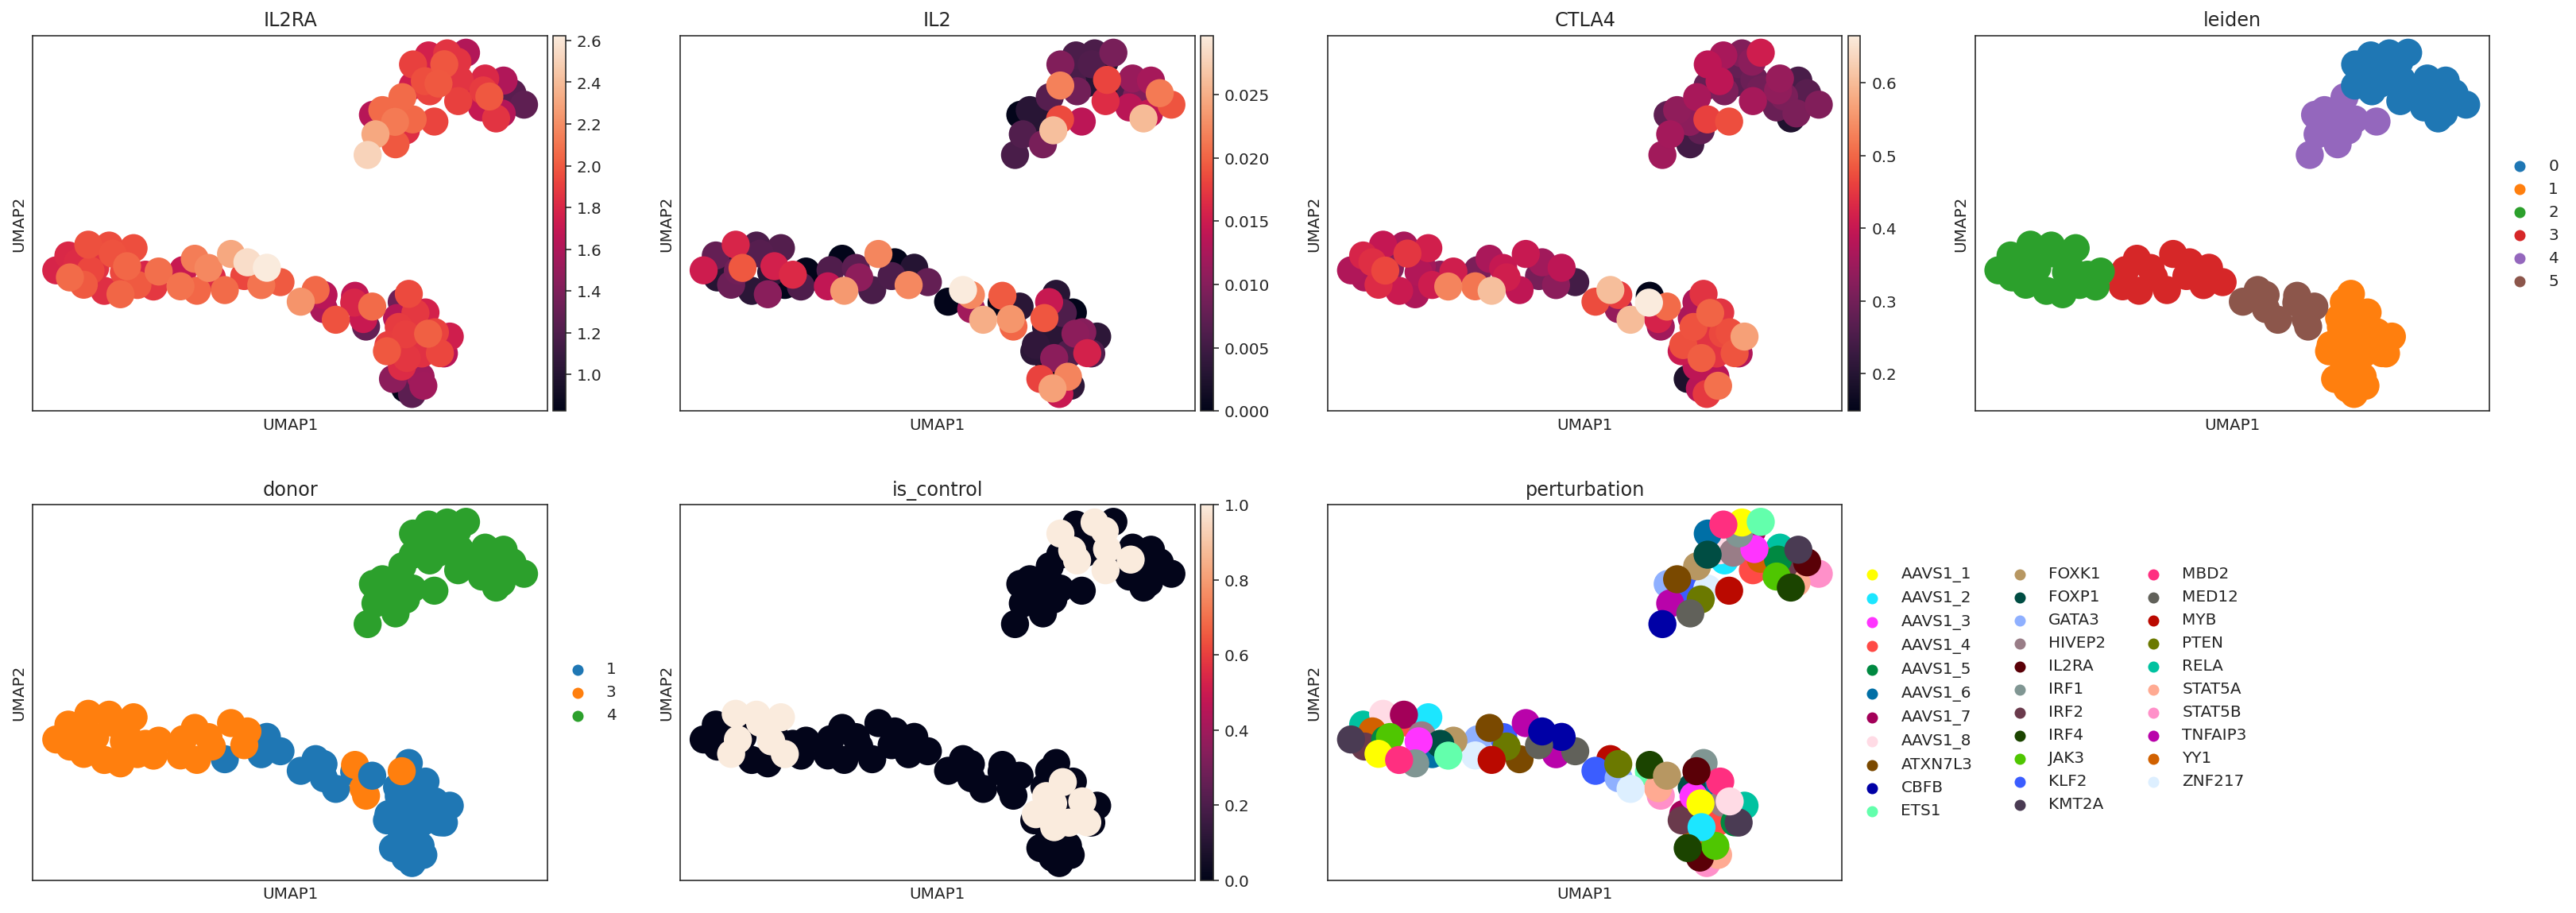

In [8]:
sc.pl.umap(expression_quantified, color = ["IL2RA", "IL2", "CTLA4", "leiden", "donor", "is_control", "perturbation"])
# Due to the small number of samples, ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
expression_quantified.obs["fake_cluster"]="all_one_cluster"
expression_quantified.obs.fake_cluster = expression_quantified.obs.fake_cluster.astype("category")
expression_quantified.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [9]:
perturbed_genes = set(list(expression_quantified.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(expression_quantified.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(expression_quantified.var.index)
genes_keep = expression_quantified.var.index[expression_quantified.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
expression_quantified_orig = expression_quantified.copy()
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))

These genes were perturbed but not measured:
set()
This many variable genes will be kept and used by CO:
2343


In [10]:
# final form, ready to save
expression_quantified = expression_quantified_orig[:,list(genes_keep)]
expression_quantified.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
expression_quantified.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)

In [11]:
os.makedirs("perturbations/freimer", exist_ok = True)
expression_quantified.write_h5ad("perturbations/freimer/test.h5ad")